In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

data = pd.read_csv('flights.csv')

# просмотрим базовую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flight_id         118 non-null    int64  
 1   arrival_airport   118 non-null    object 
 2   model             118 non-null    object 
 3   duration_in_mins  118 non-null    int64  
 4   places_taken      118 non-null    int64  
 5   amount            118 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.7+ KB


## Вывод:
#### В датасете 2 строковых столбца, 1 столбцов типа float, 3 столбца типа int
#### В датасете содержится 118 строк (записей)

## Вспомогательные функции

In [189]:

def values_inside_iqr_for(series):
    median = series.median()
    print('Медиана ' + series.name + ' = ' + str(median))
    top_quantile = series.quantile(0.75)
    bottom_quantile = series.quantile(0.25)
    iqr = top_quantile - bottom_quantile
    print('IQR ' + series.name + ' = ' + str(iqr))
    lower_bound = bottom_quantile - (1.5 * iqr)
    upper_bound = top_quantile + (1.5 * iqr)
    print('Нижняя граница выброса ' + series.name + ' = ' + str(lower_bound))
    print('Верхняя граница выброса ' + series.name + ' = ' + str(upper_bound))
    return series.between(lower_bound, upper_bound)
    
def display_group_data_for(grouped_data):
    grouped_data.hist()
    print('Mean: ' + str(grouped_data.mean()))
    print('Min: ' + str(grouped_data.min()))
    print('Max: ' + str(grouped_data.max()))
    print('Median: ' + str(grouped_data.median()))

## Разберем основные столбцы

### Аэропорты прибытия (arrival_airport)

In [190]:
print(data.arrival_airport.value_counts(dropna=False))
print(data.arrival_airport.describe())

EGO    59
SVO    59
Name: arrival_airport, dtype: int64
count     118
unique      2
top       EGO
freq       59
Name: arrival_airport, dtype: object


### Вывод:
#### Представлены 2 направления: EGO (Белгород) и SVO (Шереметьево). Отсутсвующих значений нет

### Модели самолетов (model)

In [191]:
print(data.model.value_counts(dropna=False))
print(data.model.describe())

Sukhoi Superjet-100    59
Boeing 737-300         59
Name: model, dtype: int64
count                     118
unique                      2
top       Sukhoi Superjet-100
freq                       59
Name: model, dtype: object


### Вывод:
#### Всего представлены две модели самолетов: Sukhoi Superjet-100 и Boeing 737-300. Отсутсвующих значений нет

### Длительность каждого рейса (duration_in_mins)

50     34
100    27
99     17
51     15
49     10
101     8
98      4
102     2
103     1
Name: duration_in_mins, dtype: int64
count    118.000000
mean      74.957627
std       24.992783
min       49.000000
25%       50.000000
50%       74.500000
75%      100.000000
max      103.000000
Name: duration_in_mins, dtype: float64


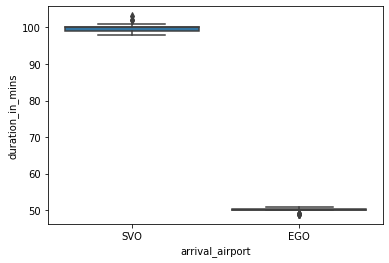

In [192]:
print(data.duration_in_mins.value_counts())
sns.boxplot(x='arrival_airport', y='duration_in_mins', data=data)
print(data.duration_in_mins.describe())


### Вывод:
#### Видим что в среднем полет до аэропорта SVO занимает от 98 до 103 минут, до аэропорта EGO от 49-51 минуту. Выбросов или пропущенных значений нет.

### Количество пассажиров на рейсе (places_taken)

97     0.152542
96     0.084746
87     0.042373
110    0.033898
95     0.033898
106    0.033898
115    0.033898
109    0.033898
94     0.025424
79     0.025424
Name: places_taken, dtype: float64
count    118.000000
mean     101.652542
std       14.295643
min       64.000000
25%       95.000000
50%       97.000000
75%      111.750000
max      130.000000
Name: places_taken, dtype: float64


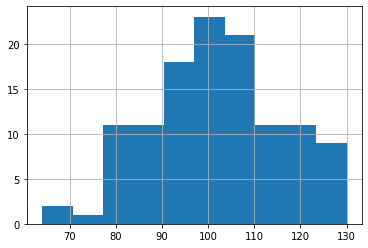

In [193]:
display_normalized_values_for(data.places_taken)
data.places_taken.hist()
print(data.places_taken.describe())

### Вывод:
#### Видим нормальное распределение пассажиров на рейсах. Выбросов нет (учитывая различную пассажировместимость моделей самолетов). Минимальное количество пассажиров на рейсе - 64, максимальное - 130. Отсутсвующих значений нет

## Добавим внешние данные

### Количество мест в самолетах на рейсе:

In [194]:
# данные из Google о модели самолета
model_seats_count = {'Sukhoi Superjet-100': 98, 
                     'Boeing 737-300': 149}

if 'seats_in_plane' not in data.columns:
    seats_in_plane = data.model.apply(lambda x: model_seats_count[x])
    data.insert(4, 'seats_in_plane', seats_in_plane)
    
    #так же добавим количество пустых мест на рейсе
    free_seats = data.seats_in_plane - data.places_taken
    data.insert(6, 'free_seats', free_seats)

### Количество потребляемого самолетом топлива и его стоимость:

In [195]:
# данные из Wikipedia о модели самолета
model_fuel_consumption = {'Sukhoi Superjet-100': 1700,
                          'Boeing 737-300': 2400}

if 'fuel_consumption' not in data.columns:
    hour_fuel_consumption = data.model.apply(lambda x: model_fuel_consumption[x])

    # рассчитаем количество потребляемого топлива за рейс
    flight_fuel_consumption = (data.duration_in_mins / 60) * hour_fuel_consumption
    data.insert(3, 'fuel_consumption', flight_fuel_consumption)
    
    # рассчитаем стоимость топлива на рейс. данные о стоимости взяты с 
    # https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/
    # Видим что для Анапы стоимость составляет 41 754 рубля за тонну. (без НДС, но я не силен в экономике РФ, поэтому оставим так)
    # Умножим стоимость на 1.2, так как самолеты явно заполняют с запасом + погрешности физических свойств топлива
    # в зависимости от температуры, а так же разный расход в зависимости от условий полета
    fuel_price = (data.fuel_consumption * 41754 / 1000) * 1.2
    data.insert(4, 'fuel_price', fuel_price)

### Рассчитаем прибыль на основании стоимости топлива (с учетом доп затрат) и стоимости всех купленных билетов на рейс

In [196]:
data['income'] = data.amount - data.fuel_price

## Рассмотрим новые данные

### Количество пустых мест на рейсе

0
Mean: arrival_airport
EGO     7.813559
SVO    35.881356
Name: free_seats, dtype: float64
Min: arrival_airport
EGO     1
SVO    19
Name: free_seats, dtype: int64
Max: arrival_airport
EGO    34
SVO    52
Name: free_seats, dtype: int64
Median: arrival_airport
EGO     3
SVO    37
Name: free_seats, dtype: int64


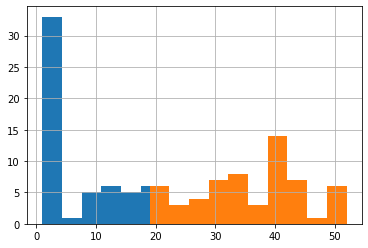

In [197]:
# убедимся что количество пустых мест на рейсе не имеет значений ниже 0
print(len(data[data.free_seats<0]))

## Выведем количество пустых мест на каждом из направлений
seats_data = data.groupby(by=['arrival_airport'])['free_seats']
display_group_data_for(seats_data)

### Выводы:
##### Видно что рейсы в аэропорт SVO имеют очень большое количество свободных мест (минимум 19 мест свободно, максимум 52). В среднем 35 мест свободны на рейсе. При этом на рейсах в EGO свободных мест гораздо меньше, в среднем 7 мест (медианное значение 3)
##### Возможно, имело бы смысл использовать на рейсах в SVO другие типы самолетов с меньшей пассажировместимостью и, следовательно, меньшими затратами на топливо с целью экономии средств. (Если такие самолеты доступны, разумеется)

### Рассмотрим матрицу корреляций, чтобы убедиться что длительность полета, количество затрачиваемого топлива и его стоимость прямо коррелируют между собой

In [198]:
data[['fuel_consumption', 'duration_in_mins', 'fuel_price']].corr()

# Видим прямую зависимость всех трех параметров, следовательно расчеты верны

,fuel_consumption,duration_in_mins,fuel_price
fuel_consumption,1.000000,0.999946,1.000000
duration_in_mins,0.999946,1.000000,0.999946
fuel_price,1.000000,0.999946,1.000000


### Проведем анализ прибыли с рейса

0
Mean: arrival_airport
EGO    6.393335e+05
SVO    1.442497e+06
Name: income, dtype: float64
Min: arrival_airport
EGO     460018.2
SVO    1197580.8
Name: income, dtype: float64
Max: arrival_airport
EGO     695737.836
SVO    1685580.800
Name: income, dtype: float64
Median: arrival_airport
EGO     675418.200
SVO    1430184.992
Name: income, dtype: float64


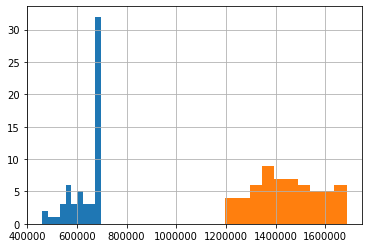

In [199]:
# убедимся что нет убыточных рейсов
print(len(data[data.income<0]))

## Выведем количество пустых мест на каждом из направлений
income_data = data.groupby(by=['arrival_airport'])['income']
display_group_data_for(income_data)

## Выводы:
##### Видим что прибыль с рейсов в SVO приблизительно в 2-3 раза привышает прибыль с рейсов в EGO. Полагаю, это связано с более высокой стоимостью билетов на рейс в Москву, чем в Белгород. При этом вряд ли стоит наращивать количество рейсов в Москву, поскольку уже существующие рейсы не всегда заполнены. 
##### Максимальная прибыль составила около 1700000р, минимальная 460000 (разумеется, здесь не учтены все сопутствующие расходы, как то зарплата сотрудников, амортизация авиапарка и т д)

 ### Рассмотрим общую таблицу корреляции всех параметров

In [200]:
data.corr()

,flight_id,fuel_consumption,fuel_price,duration_in_mins,seats_in_plane,places_taken,free_seats,amount,income
flight_id,1.000000,-0.899654,-0.899654,-0.899255,-0.900023,-0.705965,-0.787902,-0.872855,-0.864735
fuel_consumption,-0.899654,1.000000,1.000000,0.999946,0.999719,0.803285,0.858557,0.974770,0.966433
fuel_price,-0.899654,1.000000,1.000000,0.999946,0.999719,0.803285,0.858557,0.974770,0.966433
duration_in_mins,-0.899255,0.999946,0.999946,1.000000,0.999446,0.802897,0.858469,0.974231,0.965821
seats_in_plane,-0.900023,0.999719,0.999719,0.999446,1.000000,0.805490,0.857077,0.976290,0.968226
places_taken,-0.705965,0.803285,0.803285,0.802897,0.805490,1.000000,0.385062,0.907523,0.919627
free_seats,-0.787902,0.858557,0.858557,0.858469,0.857077,0.385062,1.000000,0.731450,0.708370
amount,-0.872855,0.974770,0.974770,0.974231,0.976290,0.907523,0.731450,1.000000,0.999397
income,-0.864735,0.966433,0.966433,0.965821,0.968226,0.919627,0.708370,0.999397,1.000000


#### видим прямую корреляцию прибыли со всеми параметрами, что очевидно, поскольку выборка достаточно небольшая и все параметры напрямую связаны с прибылью - в Москву летает больше людей и стоимость билетов выше, при этом длительность полета не сильно превышает длительность полета в Белгород.